In [54]:
using Revise, Plots, LinearAlgebra, Random

In [55]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

1D

In [56]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

In [57]:
n_coarse_grid = 21
n_plt_grid = 201

coarse_grids = grid(domain, n_coarse_grid)
plt_grids = grid(domain, n_plt_grid)
hm_grid = grid(domain[1, :], n_plt_grid)

plot_size = (400, 400) .* 1
plt = heatmap(xlims=domain[1], ylims=domain[2], color=:viridis, size=plot_size, grid=false)
nothing

In [68]:
ops = gaussian_operators_2D(0.06, coarse_grids)

Operators(var"#ϕ#553"{var"#gauss2D#552"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(var"#gauss2D#552"{Float64, Int64, Vector{Float64}, Vector{Float64}}(138.88888888888889, 441, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]), 441, Core.Box(var"#ϕ#553"{var"#gauss2D#552"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(#= circular reference @-2 =#))), var"#Φ#554"(Core.Box(var"#ϕ#553"{var"#gauss2D#552"{Float64, Int64, Vector{Float64}, Vector{Float64}}, Int64}(var"#gauss2D#552"{Float64, Int64, Vector{Float64}, Vector{Float64}}(138.88888888888889, 441, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45  …  0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]), 441, Core.Box(#= circular refe

## Pre-certificate

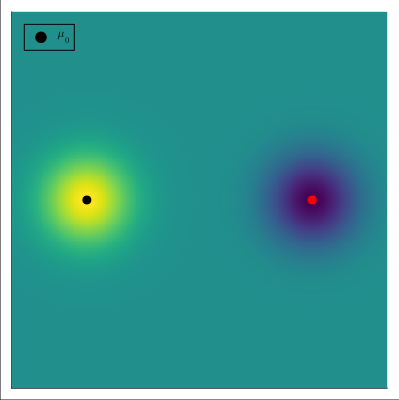

In [ ]:
# Easy case
x0 = [[0.2, 0.8], [0.5, 0.5]]
a0 = [1.0, -1.0]

# Close positive spikes
# x0 = [[0.48, 0.52], [0.5, 0.5]]
# x0 = [[0.49, 0.51], [0.5, 0.5]]
# a0 = [1.0, 1.0]

# Degenerate case
# x0 = [[0.46, 0.54], [0.5, 0.5]]
# a0 = [1.0, -1.0]

# 9 spikes
# x0 = [[0.043884, 0.197886, 0.247599, 0.391996, 0.479156, 0.589361, 0.732977, 0.901393, 0.990329], 
#       [0.623665, 0.543818, 0.779985, 0.699169, -0.780151, -0.096867, -0.235746, 0.472221, 0.434011]]
# a0 = [0.779985, 0.543818, 0.623665, -0.780151, 0.699169, 0.472221, 0.434011, -0.235746, -0.096867]

μ0 = DiscreteMeasure(x0, a0)

ηV = build_ηV(μ0, ops, plt_grids)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, hm_grid, hm_grid, ηV', color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", markersize=5, colorscheme=get_cmap(:red_black))


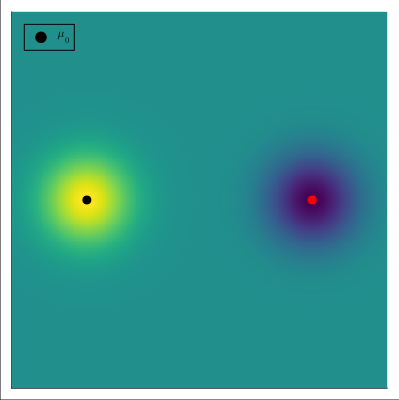

In [ ]:
y0 = ops.Φ(μ0...)

function add_noise(y0, δ)
    w = randn(length(y0))
    w = w / norm(w) * δ
    y = y0 + w
    return y
end

# Add noise to the observation y = y0 + w
noise_level = 0.0001
Random.seed!(15)
δ = noise_level * norm(y0)
y = add_noise(y0, 0 * δ)

plt_obs = deepcopy(plt)

heatmap!(plt_obs, hm_grid, hm_grid, ops.adjΦ(y, grid=plt_grids), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", markersize=5, colorscheme=get_cmap(:red_black))


FH iterations:  33    Time: 0:00:02

0.03853712123581045

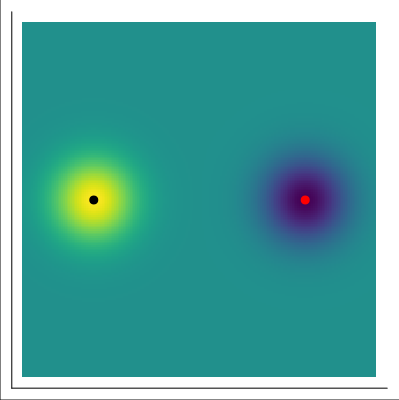

In [ ]:

prob_FH = BLASSO(y, ops, domain, n_coarse_grid)
solve!(prob_FH, :FH, options=Dict(:verbose => false, :maxits => 50, :store_reg_path => true, :τδ => 1.01δ, :c => 0.1, :η_tol => 1e-5))
display(prob_FH.λ)

plt_FH = heatmap(hm_grid, hm_grid, ηV', color=:viridis, size=plot_size)
plot_spikes!(plt_FH, prob_FH.μ, colorscheme=get_cmap(:red_black))

┌ Info: Saved animation to c:\Users\ladis\OneDrive - University of Warwick\Year 4\Super resolution\Codes\SparseSpikes\notebooks\homotopy\reg_path.gif
└ @ Plots C:\Users\ladis\.julia\packages\Plots\HNuj5\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\notebooks\\homotopy\\reg_path.gif")
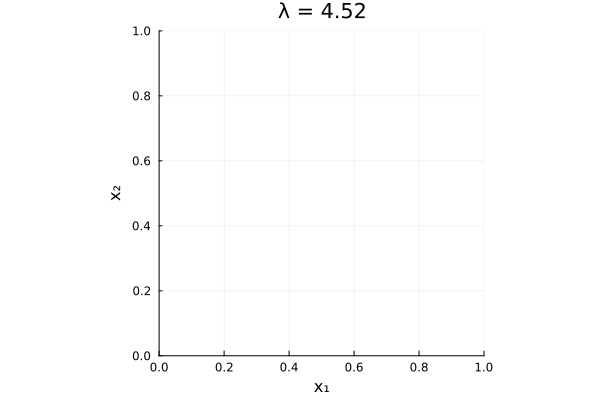

In [73]:
λs, μs = values(prob_FH.reg_path)
x_paths, a_paths = build_reg_paths(λs, μs, C=1e10)
animate_reg_path_2D(λs, x_paths, a_paths, [[0, 1], [0, 1]], "reg_path.gif", fps=2)

NODE iterations:  4516    Time: 0:00:18

"total = 4523, corrections = 4523"

0.0004531840813140134

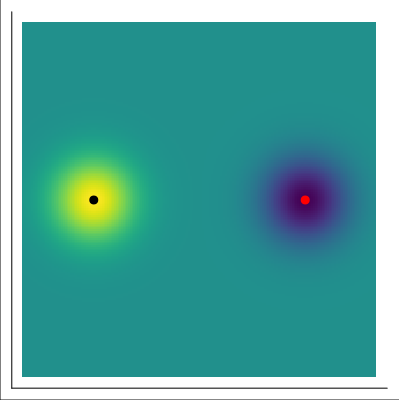

In [ ]:
prob_NODE = BLASSO(y, ops, domain, n_coarse_grid)
solve!(prob_NODE, :NODE, options=Dict(:verbose => false, :store_reg_path => true, :maxits => 10000, :h => 1e-3, :η_tol => 1e-4))
display(prob_NODE.λ)

plt_NODE = heatmap(hm_grid, hm_grid, prob_NODE.η(plt_grids), color=:viridis, size=plot_size)
plot_spikes!(plt_NODE, prob_NODE.μ, colorscheme=get_cmap(:red_black))

┌ Info: Saved animation to c:\Users\ladis\OneDrive - University of Warwick\Year 4\Super resolution\Codes\SparseSpikes\notebooks\homotopy\reg_path.gif
└ @ Plots C:\Users\ladis\.julia\packages\Plots\HNuj5\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\notebooks\\homotopy\\reg_path.gif")
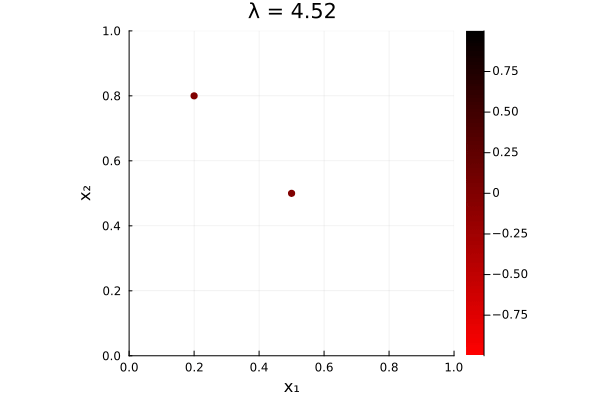

In [187]:
λs, μs = values(prob_NODE.reg_path)
x_paths, a_paths = build_reg_paths(λs, μs, C=1e10)
animate_reg_path_2D(λs, x_paths, a_paths, [[0, 1], [0, 1]], "reg_path.gif", fps=10, step=100)